In [299]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

The wave equation can be expressed using the D'Alembartian:

\begin{equation}
\Box\ \psi = -\frac{\partial^2\ \psi}{\partial\ t^2} + \frac{\partial^2\ \psi}{\partial\ x^2}\ =\ 0
\end{equation}

We can re-write this as a set of first order equations:
\begin{align}
&\partial_t\ \psi\ =\ \Pi \\\\
&\partial_t\ \Pi + \partial_x\ \Phi = 0 \\\\
&\partial_x\ \Pi + \partial_t\ \Phi = 0 
\end{align}
where $\Phi = \partial_x\ \psi$ and $\Pi = -\partial_t\ \psi$.

##Finite Differences

We can discretize the partial derivative in x as follows: 
\begin{equation}
\frac{\partial\ f}{\partial\ x}(x_j) = \frac{f(x_{j+1})\ -\ f(x_{j-1})}{x_{j+1} - x_{j-1}}.
\end{equation}

We can assume a periodic domain with N points, labeled 0 to N-1. Grid points $x_j\ =\ 2\ \pi\ j\ /\ N$.

In [487]:
def FD_Derivative(f):
    """
    Takes in a numpy array f containing f(x_j) for all grid
    points and returns the array of the derivatives for all
    points.
    """
    N = len(f)
    index_plus = np.roll(np.arange(N),-1)
    index_minus = np.roll(np.arange(N),1)
    x = np.arange(N)*2*np.pi/N
    dx = np.mod(x[index_plus]-x[index_minus], 2.0*np.pi)
    return (f[index_plus] - f[index_minus])/dx

def Avg_Err(f1, f2):
    N = len(f)
    return np.sqrt(np.sum((f1-f2)**2)/N)

In [488]:
err_smooth = np.zeros(1000)
err_nsmooth = np.zeros(1000)
for i in xrange(1000):
    N = (i+1)*10
    x = np.arange(N)*2*np.pi/N
    f = np.exp(-np.cos(x))
    g = np.abs(np.cos(x + 1e-8))
    f_analytic = np.sin(x)*np.exp(-np.cos(x))
    g_analytic = np.sign(np.cos(x))*(-np.sin(x + 1e-8))
    f_numeric = FD_Derivative(f)
    g_numeric = FD_Derivative(g)
    err_smooth[i] = Avg_Err(f_analytic, f_numeric)
    err_nsmooth[i] = Avg_Err(g_analytic, g_numeric)

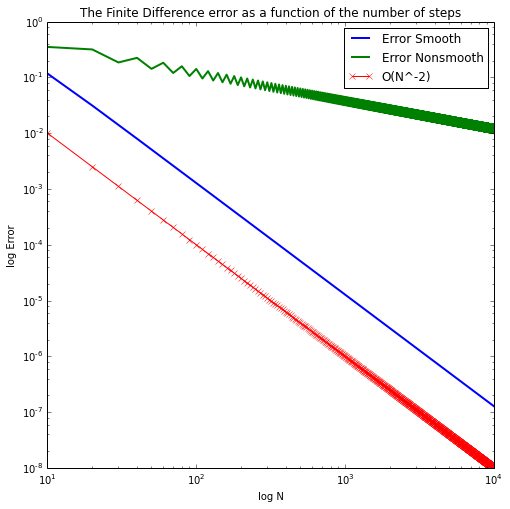

In [489]:
N = np.arange(1, 1001)*10
fig, ax = plt.subplots(figsize=(8,8))
ax.loglog(N, err_smooth,linewidth=2.0, label='Error Smooth')
ax.loglog(N, err_nsmooth,linewidth=2.0, label='Error Nonsmooth')
ax.loglog(N, N**(-2.0),'r-x', label='O(N^-2)')
ax.set_title('The Finite Difference error as a function of the number of steps')
ax.set_xlabel('log N')
ax.legend(loc='best')
ax.set_ylabel('log Error');

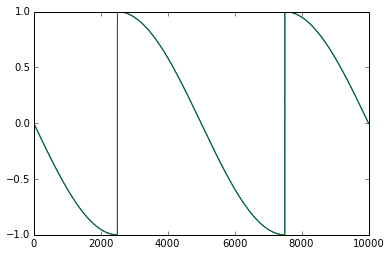

In [490]:
plt.plot(g_analytic)
plt.plot(g_numeric)

## Spectral representation

Using a finite fourier transform: 
\begin{equation}
f(x)\ =\ \sum \limits_{k = -N/2}^{N/2-1} f_k\ e^{i\ k\ x}
\end{equation}

where
\begin{equation}
f_k\ =\ \frac{1}{N}\sum \limits_{j = 0}^{N-1} f(x_j)\ e^{i\ k\ x_j}
\end{equation} 

Under this approximation (approximation since we only use terms up to N in the sum), the first derivative is given by:
\begin{equation}
f^{'}(x)\ =\ \sum \limits_{k = 0}^{N-1}D_{j k} f(x_k)
\end{equation}

where the derivative matrix $D_{j k}$ is given by
\begin{equation}
D_{j k} = \left\{
            \begin{array}{ll}
                \frac{1}{2}(-1)^{k+j} cot\frac{\pi (j-k)}{N} & \quad k \neq j \\
                0 & \quad k = j
            \end{array}
            \right.
\end{equation}

In [491]:
def SP_Derivative(f):
    N = len(f)
    j, k = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    D = 0.5*(-1)**(j+k)/np.tan(np.pi*(j-k)/N);
    D[D == np.inf] =0
    return np.dot(D, f)

In [492]:
err_smooth = np.zeros(100)
err_nsmooth = np.zeros(100)
for i in xrange(100):
    N = (i+1)*10
    x = np.arange(N)*2*np.pi/N
    f = np.exp(-np.cos(x))
    g = np.abs(np.cos(x + 1e-8))
    f_analytic = np.sin(x)*np.exp(-np.cos(x))
    g_analytic = np.sign(np.cos(x))*(-np.sin(x + 1e-8))
    f_numeric = SP_Derivative(f)
    g_numeric = SP_Derivative(g)
    err_smooth[i] = Avg_Err(f_analytic, f_numeric)
    err_nsmooth[i] = Avg_Err(g_analytic, g_numeric)

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


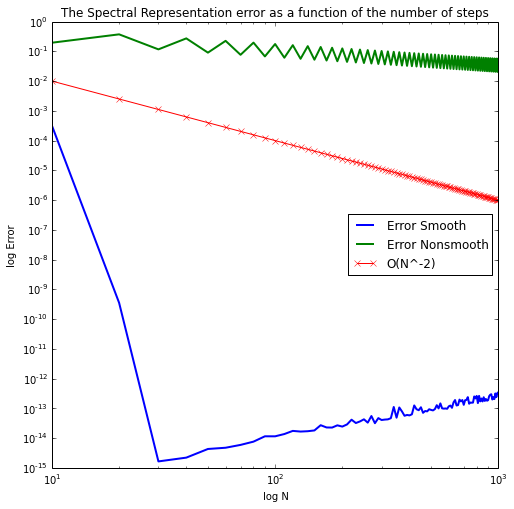

In [493]:
N = np.arange(1, 101)*10
fig, ax = plt.subplots(figsize=(8,8))
ax.loglog(N, err_smooth,linewidth=2.0, label='Error Smooth')
ax.loglog(N, err_nsmooth,linewidth=2.0, label='Error Nonsmooth')
ax.loglog(N, N**(-2.0),'r-x', label='O(N^-2)')
ax.set_title('The Spectral Representation error as a function of the number of steps')
ax.set_xlabel('log N')
ax.legend(loc='best')
ax.set_ylabel('log Error');

In [494]:
def WaveRHS(u, derivfn):
    """
    Takes as input array u = [psi, pi, phi] and returns the first time derivatives at all grid points.
    The derivfn specifies which function should be used to calculate the derivatives. 
    Returns an array [d_t psi, d_t pi, d_t phi].
    """
    return np.array([-u[1], -derivfn(u[2]), -derivfn(u[1])])

def RungeKutta4(u, dt, derivfn):
    """
    Given u(t) returns u(t+dt). 
    """
    y = np.array(u)
    k1 = dt*WaveRHS(y, derivfn)
    k2 = dt*WaveRHS(y+k1/2, derivfn)
    k3 = dt*WaveRHS(y+k2/2, derivfn)
    k4 = dt*WaveRHS(y+k3, derivfn)
    
    return y + (k1 + 2*k2 + 2*k3 + k4)/6
    

We initially set up $\Psi\ (x) = e^{-4(x-\pi)^2}$ and $\Pi\ (x) = 0$ with $\Phi\ (x) = \partial_x\ \Psi\ (x)$. Evolve $u\ =\ (\Psi, \Pi, \Phi)$ using the following specs: $\Delta t = 0.3, N = 100$ for 200 steps.

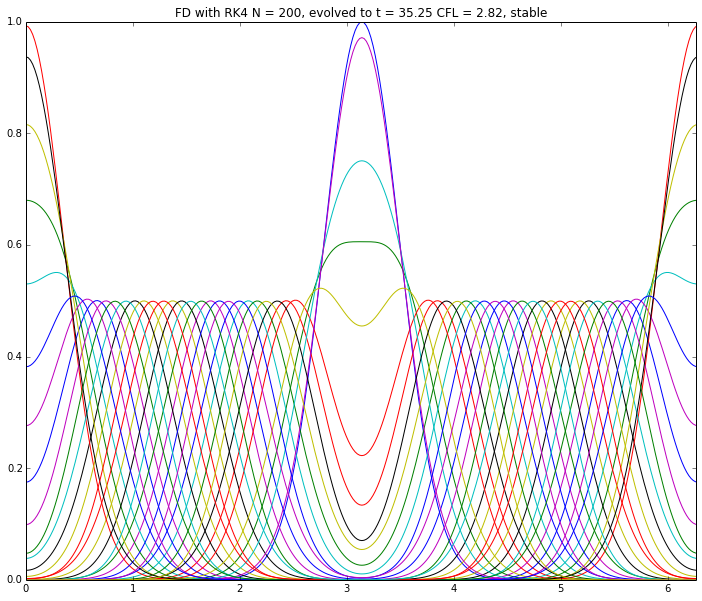

In [526]:
N = 300
dt = 2.82 * 2*np.pi/N
Nsteps = 200
derivfn = FD_Derivative
x = np.arange(N)*2.0*np.pi/N
psi = np.exp(-4.0*(x-np.pi)**2.0)
pi = np.zeros_like(psi)
phi = derivfn(psi)
snapshots = [0]*Nsteps
snapshots[0] = np.array([psi,pi,phi])
for i in xrange(Nsteps-1):
    snapshots[i + 1] = RungeKutta4(snapshots[i], dt, derivfn)
snapshots = np.array(snapshots)
fig, ax = plt.subplots(figsize=(12,10))
for i in xrange(0, Nsteps,6):
    ax.plot(x, snapshots[i,0,:])
ax.set_title('FD with RK4 N = 200, evolved to t = 35.25 CFL = 2.82, stable')
ax.axis('tight');

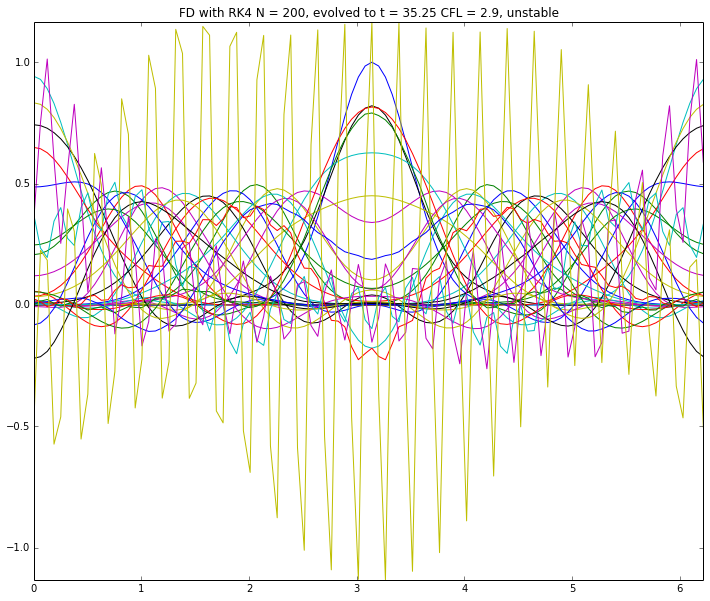

In [513]:
N = 100
dt = 2.91 * 2*np.pi/N
Nsteps = 200
derivfn = FD_Derivative
x = np.arange(N)*2.0*np.pi/N
psi = np.exp(-4.0*(x-np.pi)**2.0)
pi = np.zeros_like(psi)
phi = derivfn(psi)
snapshots = [0]*Nsteps
snapshots[0] = np.array([psi,pi,phi])
for i in xrange(Nsteps-1):
    snapshots[i + 1] = RungeKutta4(snapshots[i], dt, derivfn)
snapshots = np.array(snapshots)
fig, ax = plt.subplots(figsize=(12,10))
for i in xrange(0, Nsteps,6):
    ax.plot(x, snapshots[i,0,:])
ax.set_title('FD with RK4 N = 200, evolved to t = 35.25 CFL = 2.9, unstable')
ax.axis('tight');

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


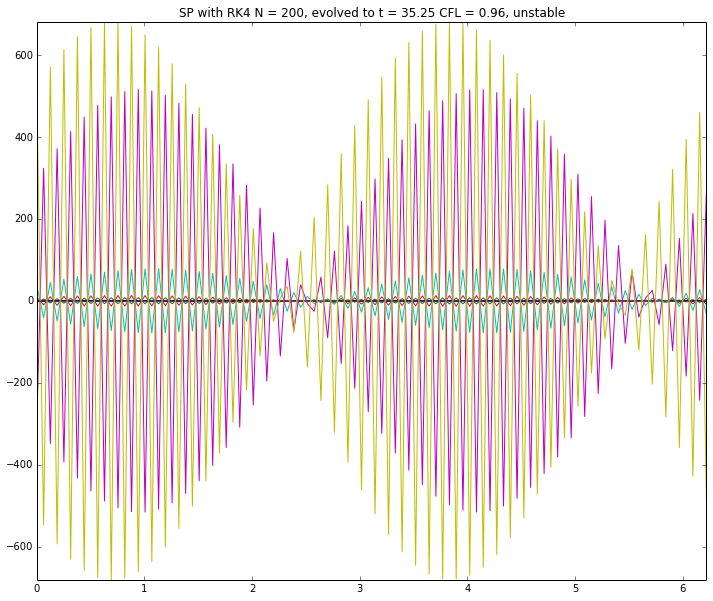

In [517]:
N = 100
dt = 0.95 * 2*np.pi/N
Nsteps = 200
derivfn = SP_Derivative
x = np.arange(N)*2.0*np.pi/N
psi = np.exp(-4.0*(x-np.pi)**2.0)
pi = np.zeros_like(psi)
phi = derivfn(psi)
snapshots = [0]*Nsteps
snapshots[0] = np.array([psi,pi,phi])
for i in xrange(Nsteps-1):
    snapshots[i + 1] = RungeKutta4(snapshots[i], dt, derivfn)
snapshots = np.array(snapshots)
fig, ax = plt.subplots(figsize=(12,10))
for i in xrange(0, Nsteps,6):
    ax.plot(x, snapshots[i,0,:])
ax.set_title('SP with RK4 N = 200, evolved to t = 35.25 CFL = 0.96, unstable')
ax.axis('tight');

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


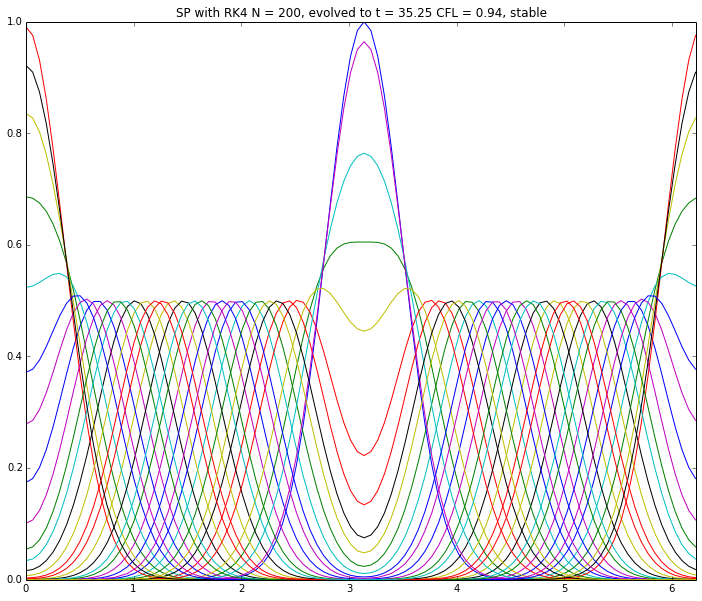

In [527]:
N = 100
dt = 0.94 * 2*np.pi/N
Nsteps = 200
derivfn = SP_Derivative
x = np.arange(N)*2.0*np.pi/N
psi = np.exp(-4.0*(x-np.pi)**2.0)
pi = np.zeros_like(psi)
phi = derivfn(psi)
snapshots = [0]*Nsteps
snapshots[0] = np.array([psi,pi,phi])
for i in xrange(Nsteps-1):
    snapshots[i + 1] = RungeKutta4(snapshots[i], dt, derivfn)
snapshots = np.array(snapshots)
fig, ax = plt.subplots(figsize=(12,10))
for i in xrange(0, Nsteps,6):
    ax.plot(x, snapshots[i,0,:])
ax.set_title('SP with RK4 N = 200, evolved to t = 35.25 CFL = 0.94, stable')
ax.axis('tight');